In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/LPALG')

Mounted at /content/drive


In [ ]:
!pip install torchviz graphviz tensorflow-lattice pydoe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 236 kB 12.8 MB/s 
     |████████████████████████████████| 254 kB 67.1 MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4150 sha256=102c32ab40e0c7073076d6267597262315d4ca3170699d454218c9c02e3d16d4
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
  Created wheel for pydoe: filename=pyDOE-0.3.8-py3-none-any.whl size=18184 sha256=a5e60ff22f7af0b16ffbbc7f0b1148ccc03ee1adc3680776fb320fdc8aa815e6
  Stored in directory: /root/.cache/pip/wheels/83/ce/8a/87b25c685bfeca1872d13b8dc101e087a9c6e3fb5ebb47022a
Successfully built torchviz pydoe


In [150]:
import sys
import time
import common
import argparse
import datasets
import numpy as np
import pandas as pd
from pyDOE import lhs
from tqdm.notebook import tqdm, trange
from matplotlib import pyplot as plt
import estimators as estimators_lib
import tensorflow as tf
import tensorflow_lattice as tfl
plt.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format='retina'


def Oracle(table, query):
    cols, idxs, ops, vals = query
    oracle_est = estimators_lib.Oracle(table)
    return oracle_est.Query(cols, ops, vals)


def cal_true_card(query, table):
    cols, idxs, ops, vals = query
    ops = np.array(ops)
    probs = Oracle(table, (cols, idxs, ops, vals))
    return probs


def GenerateQuery(table, min_num_filters, max_num_filters, rng, dataset, unique_values, latin_sample):
    """Generate a random query."""
    num_filters = rng.randint(max_num_filters - 1, max_num_filters)
    cols, idxs, ops, vals = SampleTupleThenRandom(table, num_filters, rng, dataset, unique_values, latin_sample)
    sel = cal_true_card((cols, idxs, ops, vals), table) / float(table.cardinality)
    return cols, idxs, ops, vals, sel

# unique_value = {}
# column_interval_number = 调用函数

# lb = np.array([1] * n_column)
# ub = np.array(column_interval_number) - 1
# lhs_sample = lb + (ub - lb) * lhs(n_column, samples=lhs_n, criterion='center')
# index = np.round(lhs_sample).astype(np.int32)
# grid_mesh = np.empty_like(index, dtype=np.float32)
# for i in range(lhs_n):
#     idx = index[i, :]
#     grid_mesh[i] = [unique_intervals[j][idx[j]] for j in range(n_column)]
# sample_df = pd.DataFrame(grid_mesh, columns=[f'col_{i}' for i in range(n_column)])
# grid_a = np.array(sample_df.sort_values(by=list(sample_df.columns)))
# greatest = np.array([v[-1] for v in unique_intervals.values()]).reshape(1, -1)
# grid = np.concatenate([grid_a, greatest], axis=0)


def SampleTupleThenRandom(table, num_filters, rng, dataset, unique_values, latin_sample):
    idxs = rng.choice(len(table.columns), replace=False, size=num_filters)
    cols = np.take(table.columns, idxs)
    # If dom size >= 10, okay to place a range filter.
    # Otherwise, low domain size columns should be queried with equality.
    #ops = rng.choice(['='], size=num_filters)
    ops = rng.choice(['<=', '>=', '>', '<'], size=num_filters)
    #ops = rng.choice(['<=', '>='], size=num_filters)
    #ops = rng.choice(['<='], size=num_filters)
    #ops_all_eqs = ['='] * num_filters
    #sensible_to_do_range = [c.DistributionSize() >= 10 for c in cols]
    #ops = np.where(sensible_to_do_range, ops, ops_all_eqs)
    # if num_filters == len(table.columns):
    #     return table.columns,np.arange(len(table.columns)), ops, vals
    if latin_sample:
        vals = [np.random.choice(unique_values[i], size=1)[0] for i in idxs]
    else:
        vals = []
        new_table = table.data
        s = new_table.iloc[rng.randint(0, new_table.shape[0])]
        vals = s.values
        vals = vals[idxs]
    op_a = []
    val_a = []
    for i in range(len(vals)):
        val_a.append([vals[i]])
        op_a.append([ops[i]])
    return cols, idxs, pd.DataFrame(op_a).values, pd.DataFrame(val_a).values


def dictionary_column_interval(table_size, query_set):
    # Traverse all queries to apply the intervalization skill for each column
    n_column = table_size[1]
    column_interval = {}
    for i in range(n_column):
        column_interval[i] = set()
    for query in query_set:
        _, col_idxs, _, vals, _ = query
        for i in range(len(col_idxs)):
            column_interval[col_idxs[i]].add(vals[i][0])
    for k, v in column_interval.items():
        column_interval[k] = sorted(list(v))
        least, least_2 = column_interval[k][0], column_interval[k][1]
        greatest_2, greatest = column_interval[k][-2], column_interval[k][-1]
        column_interval[k] = sorted([0, 2*least-least_2] + column_interval[k] + [2*greatest-greatest_2])
    return column_interval


def count_column_unique_interval(unique_intervals):
    # count unique query interval in each column
    return [len(v) for v in unique_intervals.values()]


def process_train_data(unique_intervals, query_set, train_size=1):
    train_size = 1
    X, Y = [], []
    origin = np.array([[0, v[-1]] for v in unique_intervals.values()]).ravel()
    for query in query_set:
        x = list(origin)
        _, col_idxs, ops, vals, sel = query
        for i in range(len(col_idxs)):
            if ops[i][0] == "<=":
                x[col_idxs[i]*2+1] = vals[i][0]
            elif ops[i][0] == "<":
                ind = unique_intervals[col_idxs[i]].index(vals[i][0]) - 1
                x[col_idxs[i]*2+1] = unique_intervals[col_idxs[i]][ind]
            elif ops[i][0] == ">":
                x[col_idxs[i]*2] = vals[i][0]
            elif ops[i][0] == ">=":
                ind = unique_intervals[col_idxs[i]].index(vals[i][0]) + 1
                x[col_idxs[i]*2] = unique_intervals[col_idxs[i]][ind]
            elif ops[i][0] == "=":
                ind = unique_intervals[col_idxs[i]].index(vals[i][0]) - 1
                x[col_idxs[i]*2] = unique_intervals[col_idxs[i]][ind]
                x[col_idxs[i]*2+1] = vals[i][0]
        X.append(x)
        Y.append(sel)
    X = np.array(X).astype(np.float32)
    Y = np.array(Y).astype(np.float32).reshape(-1, 1)
    total = np.concatenate((X, Y), axis=1)
    # total = np.unique(total, axis=0)
#     choose = np.random.choice(total.shape[0], size=round(total.shape[0]*train_size), replace=False)
#     others = list(set(range(total.shape[0])) - set(choose))
#     train, test = total[choose], total[others]
#     df_train = pd.DataFrame(train, columns=[f'col_{i}' for i in range(total.shape[1])])
    df_train = pd.DataFrame(total, columns=[f'col_{i}' for i in range(total.shape[1])])
    # boundary
    # df_train.loc[len(df_train.index)] = [0] * total.shape[1]
    # zero = [[v[-1], 0] for v in unique_intervals.values()]
    # df_train.loc[len(df_train.index)] = list(np.array(zero).ravel()) + [0.0]
    # one = [[0, v[-1]] for v in unique_intervals.values()]
    # df_train.loc[len(df_train.index)] = list(np.array(one).ravel()) + [1.0]
    
    new_train = np.array(df_train.sort_values(by=list(df_train.columns)[:-1]))
    sort_train_X, sort_train_Y = np.hsplit(new_train, [-1])

    np.random.shuffle(new_train)
    train_X, train_Y = np.hsplit(new_train, [-1])

#     df_test = pd.DataFrame(test, columns=[f'col_{i}' for i in range(total.shape[1])])
#     new_test = np.array(df_test.sort_values(by=list(df_test.columns)[:-1]))
#     test_X, test_Y = np.hsplit(new_test, [-1])
    return train_X, train_Y, sort_train_X, sort_train_Y  # , test_X, test_Y


def generate_data_new(grid, newpred):
    # delete all the zero cardinality rows
    line = pd.DataFrame(
        np.concatenate([grid, newpred], axis=1),
        columns=[f'col_{i}' for i in range(n_column)]+['card']
    )
    nozero = (line == 0).sum(axis=1)
    line = line[nozero==0].reset_index(drop=True)
    grid, pred = np.hsplit(np.array(line), [-1])
    pred = pred.astype(np.int32)
    # generate dataNew
    dataNew = pd.DataFrame(
        columns=[f'col_{i}' for i in range(n_column)],
        #index=range(n_row)
    )
    count = 0
    for i in trange(grid.shape[0]):
        df = dataNew
        grid_value = grid[i]
        for j in range(n_column):
            df = df.query(f'col_{j} <= {grid_value[j]}')
        card = pred[i][0] - df.shape[0]
        if card > 0:
            df3 = pd.DataFrame({f"col_{k}": [grid_value[k]] * card for k in range(n_column)})
            dataNew = dataNew.append(df3, ignore_index = True)
            #dataNew.iloc[count:count + card, :] = grid_value
            #count += card
            #if count > n_row:
                #print("Reached table length in ", i, grid.shape[0])
                #break
    #dataNew.dropna(axis=0, how='all', inplace=True)
    return dataNew
    
    
def execute_query(dataNew, query_set):
    diff = []
    for query in tqdm(query_set):
        df = dataNew
        _, col_idxs, ops, vals, sel = query
        for i in range(len(col_idxs)):
            op = '==' if ops[i][0] == "=" else ops[i][0]
            df = df.query(f'col_{col_idxs[i]} {op} {vals[i][0]}')
        card = 1 if round(sel * n_row) == 0 else round(sel * n_row)
        card2 = 1 if df.shape[0] == 0 else df.shape[0]
        diff.append(max(card/card2, card2/card))
    return diff


def print_error(diff, args):
    print(
        f"\n\n Q-error of Lattice (query size={args.query_size}, condition={args.num_conditions}, epoches={args.epochs}):\n"
    )
    print(f"min:    {np.min(diff)}")
    print(f"10:     {np.percentile(diff, 10)}")
    print(f"20:     {np.percentile(diff, 20)}")
    print(f"30:     {np.percentile(diff, 30)}")
    print(f"40:     {np.percentile(diff, 40)}")
    print(f"median: {np.median(diff)}")
    print(f"60:     {np.percentile(diff, 60)}")
    print(f"70:     {np.percentile(diff, 70)}")
    print(f"80:     {np.percentile(diff, 80)}")
    print(f"90:     {np.percentile(diff, 90)}")
    print(f"95:     {np.percentile(diff, 95)}")
    print(f"max:    {np.max(diff)}")
    print(f"mean:   {np.mean(diff)}")
    
    
def calc_time(tic, toc):
    total_time = toc - tic
    m, s = divmod(total_time, 60)
    h, m = divmod(m, 60)
    return f"{h:0>2.0f}:{m:0>2.0f}:{s:0>2.0f}"

In [161]:
class ResBlock(tf.keras.Model):
    def __init__(self, dim_in, dim_hidden, dim_out, act_name):
        super().__init__()
        assert dim_in == dim_out
        block = tf.keras.models.Sequential()
        block.add(tf.keras.layers.Dense(dim_in))
        block.add(tf.keras.layers.BatchNormalization())
        block.add(tf.keras.layers.Activation(act_name))
        block.add(tf.keras.layers.Dense(dim_hidden))
        block.add(tf.keras.layers.BatchNormalization())
        block.add(tf.keras.layers.Activation(act_name))
        block.add(tf.keras.layers.Dense(dim_out))
        block.add(tf.keras.layers.BatchNormalization())
        self.block = block

    
    def call(self, x):
        identity = x
        out = self.block(x)
        return tf.nn.relu(identity + out)

In [173]:
class CopulaLayer(tf.keras.Model):
    def __init__(self, dim, res_dim=[2, 10, 1], res_blocks=30, act_name='relu', lattice_size=2):
        super().__init__()
        self.dim = dim
        self.lattice_size = lattice_size
        
        self.copula_lattice = tfl.layers.Lattice(
            lattice_sizes=[self.lattice_size] * self.dim,
            interpolation='hypercube',  # simplex
            monotonicities=['increasing'] * self.dim,
            output_min= 0.0,
            output_max= 1.0,
            name='lattice',
        )

        # dim_in, dim_hidden, dim_out = res_dim
        dim_hidden, dim_out = self.dim, self.dim
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Dense(dim_hidden))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation("relu"))
        for i in range(res_blocks):
            model.add(ResBlock(dim_hidden, dim_hidden, dim_hidden, act_name=act_name))
        model.add(tf.keras.layers.Dense(dim_out))
        self.Res_model = model
    

    def get_config(self):
        config = super().get_config()
        config.update({
            "dim": self.dim,
            "lattice_size": self.lattice_size,
        })
        return config


    def call(self, x):
        # return self.copula_lattice(x)
        #x = tf.keras.layers.concatenate(x)
        x = self.Res_model(x)
        x = self.copula_lattice(x)
        return x

In [174]:
class LatticeCopulaModel(tf.keras.Model):
    def __init__(self, modelpath, dim, lattice_size=2, pwl_keypoints=None):
        super().__init__()
        self.dim = dim
        self.model_path = modelpath
        self.pwl_calibration_input_keypoints = pwl_keypoints
        self.copula = CopulaLayer(dim=dim, lattice_size=lattice_size)
        
        self.cdf_inputs = []
        for i in range(self.dim):
            self.cdf_inputs.append(
                tf.keras.layers.Input(shape=[1], name='col_%s_inf' % i))
            self.cdf_inputs.append(
                tf.keras.layers.Input(shape=[1], name='col_%s_sup' % i))

        self.calibrators = []
        for i in range(self.dim):
            self.calibrators.append(
                tfl.layers.PWLCalibration(
                    input_keypoints=np.array(
                        self.pwl_calibration_input_keypoints[i]),
                    dtype=tf.float32,
                    output_min=0.0,
                    output_max=1.0,
                    #clamp_min=True,
                    #clamp_max=True,
                    monotonicity='decreasing',
                    name='col_%s_inf_pwl' % i
                )(self.cdf_inputs[2*i]))
            self.calibrators.append(
                tfl.layers.PWLCalibration(
                    input_keypoints=np.array(
                        self.pwl_calibration_input_keypoints[i]),
                    # input_keypoints=np.linspace(
                    #     feat_mins[i],
                    #     feat_maxs[i],
                    #     num=pwl_calibration_num_keypoints),
                    dtype=tf.float32,
                    output_min=0.0,
                    output_max=1.0,
                    #clamp_min=True,
                    #clamp_max=True,
                    monotonicity='increasing',
                    name='col_%s_sup_pwl' % i
                )(self.cdf_inputs[2*i+1]))

        self.lattice_cdf = []
        for i in range(self.dim):
            self.lattice_cdf.append(
                tfl.layers.Lattice(
                    lattice_sizes=[lattice_size] * 2,
                    interpolation='hypercube',  # simplex
                    monotonicities=['increasing'] * 2,
                    output_min= 0.0,
                    output_max= 1.0,
                    name='lattice_col_%s' % i,
                )([self.calibrators[2*i], self.calibrators[2*i+1]]))
            
        self.cdf_model = tf.keras.models.Model(
            inputs=self.cdf_inputs,
            outputs= self.lattice_cdf
        )

        self.model = tf.keras.models.Model(
            inputs=self.cdf_inputs,
            outputs= self.copula(tf.keras.layers.concatenate(self.lattice_cdf))
        )
        # self.model.save('%s.hdf5' % self.model_path)
        self.model.summary()
    

    def call(self, inputs, training=True):
        x = self.cdf_model(inputs)
        x_reshape = tf.keras.layers.concatenate(x) if self.dim > 1 else x
        y = self.copula(x_reshape)
        grad = y
        for i in range(self.dim):
            grad = tf.gradients(grad, x[i])
            grad = grad[0]
        return y, x, grad
        

    def compile(self, loss, optimizer):
        super().compile()
        self.loss = loss
        self.optimizer = optimizer


    def train_step(self, data, training=True):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred, lattice_inputs, lattice_grad = self(x)
            loss1 = tf.reshape(self.loss(y, y_pred), [-1, 1])
            loss2 = tf.nn.relu(y_pred - tf.keras.backend.min(lattice_inputs))
            lb = tf.math.maximum(sum(lattice_inputs) - self.dim + 1, 0)
            loss3 = tf.nn.relu(lb - y_pred)
            loss4 = tf.nn.relu(-lattice_grad)
            loss = tf.reduce_sum(loss1 + loss2 + loss3 + loss4)
            #loss = tf.reduce_sum(loss1)
        trainable_vars = self.trainable_weights
        grads = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(grads, trainable_vars))
        return {"loss": loss, "loss1": loss1, "loss2": loss2, "loss3": loss3, "loss4": loss4}

In [175]:
class Trainer:
    def __init__(self, name, dim, pwl_keypoints=None, lattice_size=2):
        self.dim = dim
        self.model_path = './models/Lattice/model/' + name
        self.weight_path = './models/Lattice/weight/' + name
        self.pwl_keypoints = unique_intervals if pwl_keypoints is None else pwl_keypoints
        self.model = LatticeCopulaModel(modelpath=self.model_path, dim=dim, lattice_size=2, pwl_keypoints=self.pwl_keypoints)
        # self.model.build(input_shape=[(None, 1) for i in range(2*self.dim)])
        # self.model.summary()
        
    def train(self,
              X,
              y,
              lr=0.01,
              bs=20,
              epochs=3000,
              reduceLR_factor=0.5,
              reduceLR_patience=50,
              earlyStopping_patience=500,
              verbose=1,
              loss='MSE',
              opt='Adam'):
        assert X.shape[0] == y.shape[0]

        X = X.astype(np.float32)
        y = y.astype(np.float32)

        features = [X[:, i] for i in range(X.shape[1])]
        target = y
        Loss = {
            'MAE': tf.keras.losses.mean_absolute_error,
            'MSE': tf.keras.losses.mean_squared_error,
            'MAPE': tf.keras.losses.mean_absolute_percentage_error
        }

        Opt = {
            'Adam': tf.keras.optimizers.Adam(),
            'Nadam': tf.keras.optimizers.Nadam(),
            'Adagrad': tf.keras.optimizers.Adagrad(),
            'Adadelta': tf.keras.optimizers.Adadelta(),
            'Adamax': tf.keras.optimizers.Adamax(),
            'RMSprop': tf.keras.optimizers.RMSprop(),
        }
        self.model.compile(loss=Loss[loss], optimizer=Opt[opt])

        #self.model.save('%s' % self.model_path, save_format='tf')
        
        

        earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                         patience=earlyStopping_patience,
                                                         verbose=verbose,
                                                         min_delta=1e-20,
                                                         restore_best_weights=True,
                                                         mode='min')
        mcp_save = tf.keras.callbacks.ModelCheckpoint('%s.hdf5' %
                                                      self.weight_path,
                                                      save_best_only=True,
                                                      monitor='loss',
                                                      mode='min',
                                                      save_weights_only=True)
        reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(
            monitor='loss',
            factor=reduceLR_factor,
            patience=reduceLR_patience,
            verbose=verbose,
            min_delta=1e-20,
            mode='min')

        self.model.fit(features,
                       target,
                       epochs=epochs,
                       batch_size=bs,
                       verbose=1,
                       callbacks=[earlyStopping, mcp_save, reduce_lr_loss]
                       )
        # self.model.build(input_shape = (None, self.dim*2))
        # self.model.load_weights('%s.hdf5' % self.weight_path, custom_objects={"Model": Model})

        
    def load(self):
        self.model = tf.keras.models.load_model('%s.hdf5' % self.model_path)
        self.model.load_weights('%s.hdf5' % self.weight_path)

        
    def inference(self, grid):
        assert grid.shape[1] == self.dim * 2
        pred = self.model.predict(np.hsplit(grid, self.dim * 2))
        return pred

In [176]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--dataset', type=str, default='wine2', help='Dataset.')
    parser.add_argument('--latin-query', type=bool, default=True, help='latin sample of query')
    parser.add_argument('--query-size', type=int, default=10000, help='query size')
    parser.add_argument('--num-conditions', type=int, default=1, help='num of conditions')
    parser.add_argument('--epochs', type=int, default=5000, help='Number of epochs to train for.')
    parser.add_argument('--bs', type=int, default=1000, help='Batch size.')
    parser.add_argument('--lhs_n', type=int, default=10000, help='Number of lhs samples to generate for.')
    parser.add_argument('--train-size', type=float, default=0.8, help='train size')
    parser.add_argument('--lr', type=float, default=1e-2, help='learning rate')
    parser.add_argument('--loss', type=str, default='MSE', help='Loss.')
    parser.add_argument('--opt', type=str, default='Adam', help='Optimizer.')
    parser.add_argument('--lattice', type=int, default=2, help='Lattice size.')
    parser.add_argument('--seed', type=int, default=4321, help='Random seed')
    parser.add_argument('--sample', type=int, default=0, help='reload trained mode')
    #args = parser.parse_args()
    args, unknown = parser.parse_known_args()
    bs = int(args.bs)
    lr = float(args.lr)
    train_size = float(args.train_size)
    epochs = int(args.epochs)
    lattice = int(args.lattice)
    sample = int(args.sample)
    lhs_n = int(args.lhs_n)

    type_casts = {}
    table = datasets.LoadDataset(args.dataset + '.csv',
                                 args.dataset,
                                 type_casts=type_casts)
    
    print('Begin Generating Queries ...')
    time0 = time.time()
    rng = np.random.RandomState(args.seed)
    table_size = table.data.shape
    n_row, n_column = table_size[0], table_size[1]
    # unique values for every column
    read_data = pd.read_csv('./datasets/' + args.dataset + '.csv', header=None)
    read_data.columns = [f"col_{i}" for i in range(n_column)]
    unique_values = dict()
    for i in range(n_column):
        unique_values[i] = sorted(read_data[f"col_{i}"].unique())

    query_set = [
        GenerateQuery(table, 2, args.num_conditions + 1, rng, args.dataset, unique_values, args.latin_query)
        for i in trange(args.query_size)
    ]
    print('Complete Generating Queries.')

    print("\n\nCalculating intervalization...")
    time1 = time.time()
    unique_intervals = dictionary_column_interval(table_size, query_set)
    column_interval_number = count_column_unique_interval(unique_intervals)
    print("\nColumn intervals", column_interval_number, np.product(column_interval_number))
    
    print("\n\nProcessing training data...")
    train_X, train_Y, sort_train_X, sort_train_Y = process_train_data(unique_intervals, query_set)
    # train_X, train_Y, test_X, test_Y = process_train_data(unique_intervals, query_set)
    # print("  Total query:", args.query_size)
    # print("  Train query:", train_X.shape[0])
    # print("  Test  query:", test_X.shape[0])
    # print("\n\n")
    print("\n\nDone. Building Lattice...")
    name = f"{args.dataset}_{args.query_size}query_{args.num_conditions}column_{args.epochs}epoch"
    m = Trainer(name, n_column, pwl_keypoints=None)
    
    print("\n\nLattice is already built, begin training...\n")
    time2 = time.time()
    m.train(train_X,
            train_Y,
            lr=lr,
            bs=bs,
            epochs=epochs,
            loss=args.loss,
            opt=args.opt
            )
    
    print("\nFinish training")

    print("\nBegin sampling for generate dataNew")
    time3 = time.time()
    # Full-Factorial net of unique intervals
#     values = [v for v in unique_intervals.values()]
#     mesh = np.meshgrid(*values)
#     grid = np.array(mesh).T.reshape(-1, len(values)).astype(np.float32)
    
    # Latin Hypercube sampling
#     lb = np.array([v[1] for v in unique_intervals.values()])
#     ub = np.array([v[-1] for v in unique_intervals.values()])
#     lhs_sample = lhs(n_column, samples=10000, criterion='center')
#     sample_df = pd.DataFrame(lb + (ub-lb)*lhs_sample, columns=[f'col_{i}' for i in range(n_column)])
#     grid = np.array(sample_df.sort_values(by=list(sample_df.columns)))
    
    lb = np.array([1] * n_column)
    ub = np.array(column_interval_number) - 1
    lhs_sample = lb + (ub - lb) * lhs(n_column, samples=lhs_n, criterion='center')
    index = np.round(lhs_sample).astype(np.int32)
    grid_mesh = np.empty_like(index, dtype=np.float32)
    for i in range(lhs_n):
        idx = index[i, :]
        grid_mesh[i] = [unique_intervals[j][idx[j]] for j in range(n_column)]
    sample_df = pd.DataFrame(grid_mesh, columns=[f'col_{i}' for i in range(n_column)])
    grid_a = np.array(sample_df.sort_values(by=list(sample_df.columns)))
    greatest = np.array([v[-1] for v in unique_intervals.values()]).reshape(1, -1)
    grid = np.concatenate([grid_a, greatest], axis=0)
    # transform 1-input grid to 2-input extend grid
    assert grid.shape[1] == n_column
    length = grid.shape[0]
    inf = [0] * length
    grid_dict = {}
    for i in range(n_column):
        grid_dict[f'col_{i}_inf'] = inf
        grid_dict[f'col_{i}_sup'] = grid[:, i]
    extend_grid = np.array(pd.DataFrame(grid_dict))
    print("Begin model inference")
    pred = m.inference(extend_grid)
    print("Done")
    
    pred = pred[0]
    newpred = np.round(pred * n_row)  # newpred is the predict cardinality
    print("\nBegin generating table...")
    dataNew = generate_data_new(grid, newpred)

    print("\nFinish generate table, calculating Q-error on new table...")
    time4 = time.time()
    diff = execute_query(dataNew, query_set)
    print_error(diff, args)

    print(f"\noriginal table shape: {table_size}")
    print(f"  Our table shape   : {dataNew.shape}")
    time5 = time.time()

    print("\nTime passed:")
    print(" Generate Query  :  ", calc_time(time0, time1))
    print(" Build  Lattice  :  ", calc_time(time1, time2))
    print("   Training      :  ", calc_time(time2, time3))
    print("Generate New Data:  ", calc_time(time3, time4))
    print("Calculate Q-error:  ", calc_time(time4, time5))

load dataset wine2.csv done
(6497, 2)
(6497, 2)
0
1
0 106
1 187
Begin Generating Queries ...


  0%|          | 0/10000 [00:00<?, ?it/s]

Complete Generating Queries.


Calculating intervalization...

Column intervals [109, 190] 20710


Processing training data...


Done. Building Lattice...
Model: "model_39"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 col_0_inf (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 col_0_sup (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 col_1_inf (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 col_1_sup (InputLayer)         [(N

  0%|          | 0/10001 [00:00<?, ?it/s]


Finish generate table, calculating Q-error on new table...


  0%|          | 0/10000 [00:00<?, ?it/s]



 Q-error of Lattice (query size=10000, condition=1, epoches=5000):

min:    1.0
10:     1.9984508133230054
20:     2.0337379788743495
30:     2.215733424939883
40:     3.2233883058470765
median: 15.0
60:     78.0241935483871
70:     260.0
80:     882.0
90:     2803.0
95:     5156.0
max:    6485.0
mean:   734.612474924787

original table shape: (6497, 2)
  Our table shape   : (12900, 2)

Time passed:
 Generate Query  :   00:00:09
 Build  Lattice  :   00:00:04
   Training      :   00:07:27
Generate New Data:   00:01:29
Calculate Q-error:   00:00:21


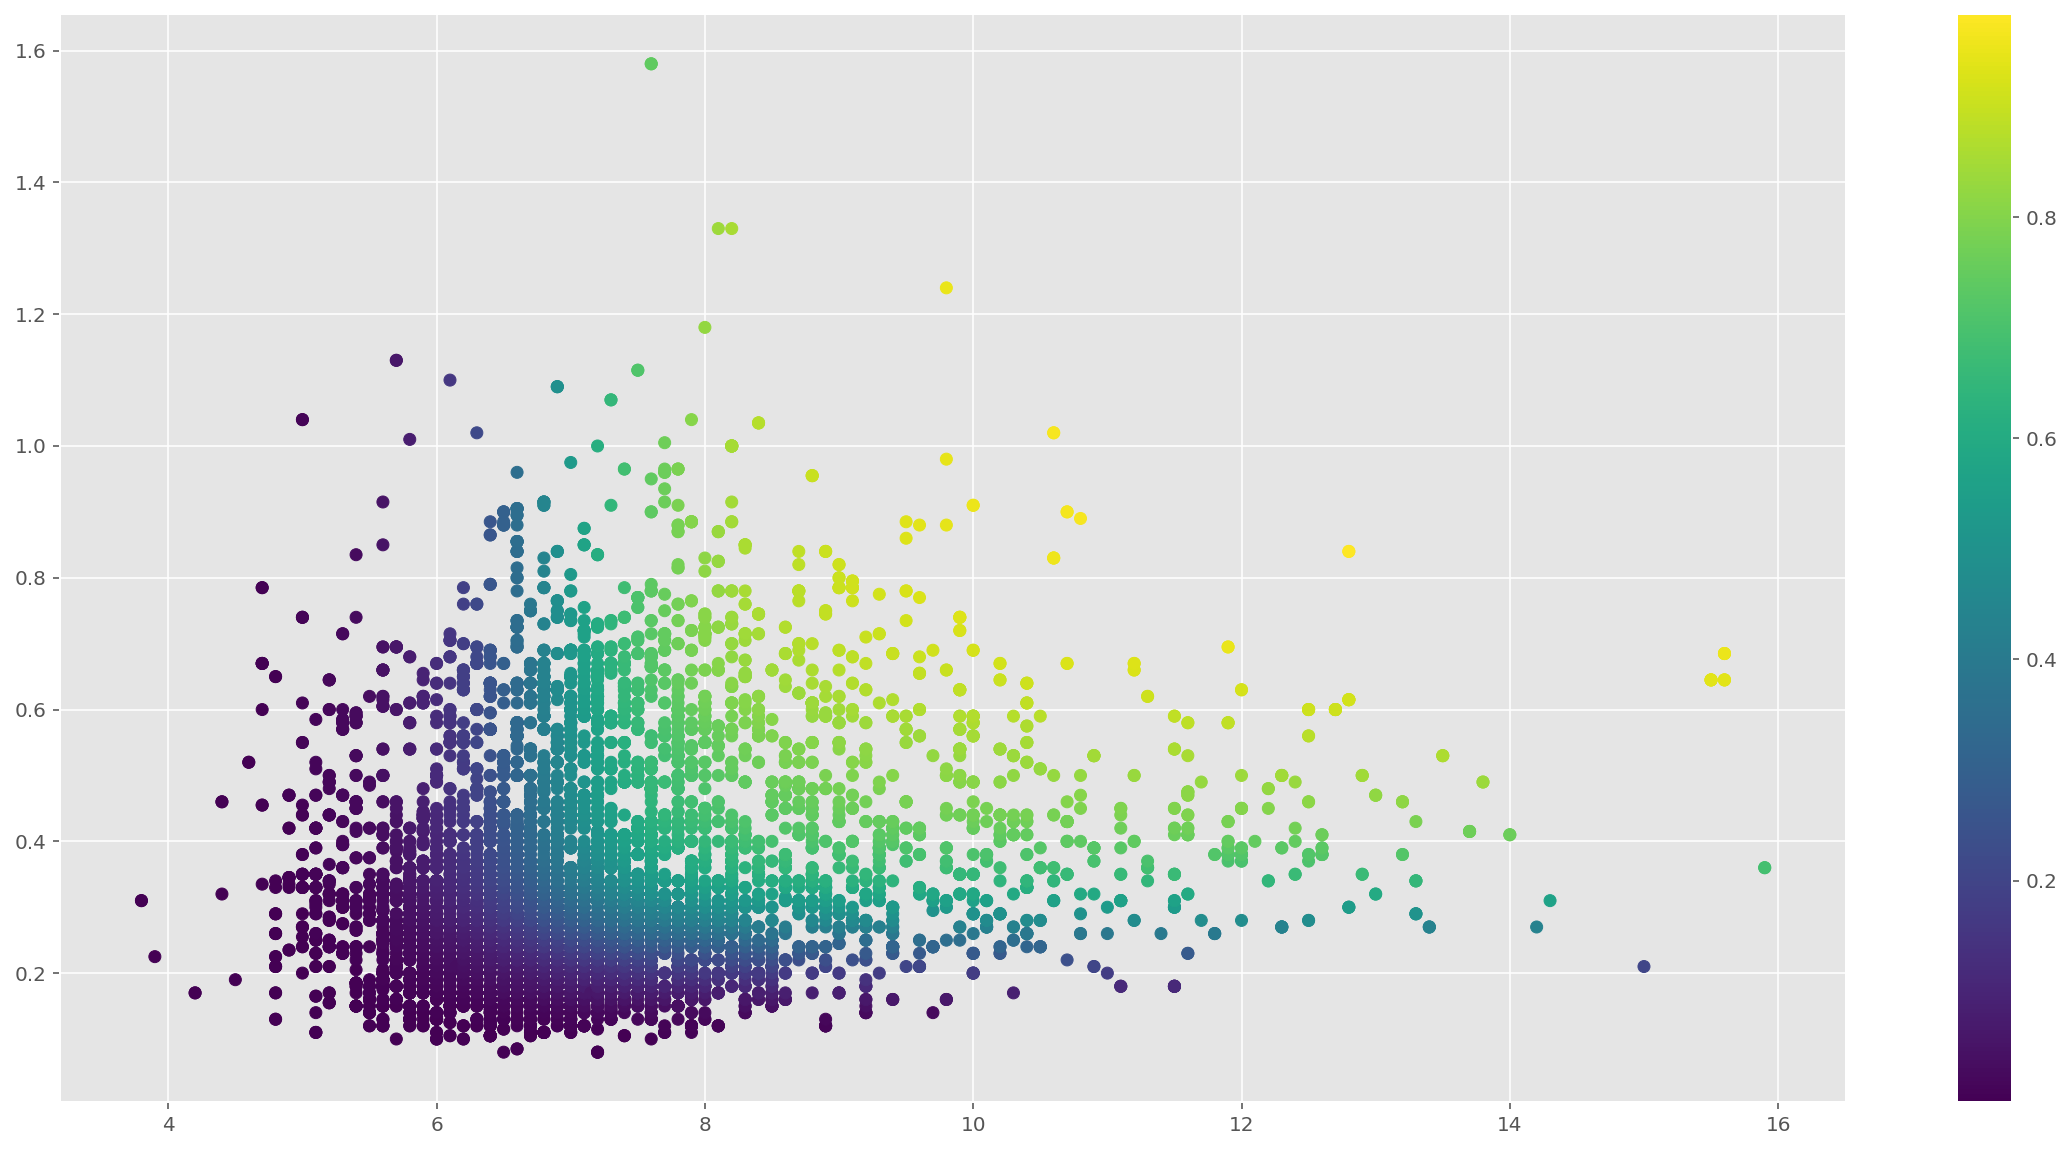

In [ ]:
fig = plt.figure(figsize=(20, 10))
ax = fig.gca()
X = train_X[:, 1]
Y = train_X[:, 3]
V = train_Y
sc = ax.scatter(X, Y, c=V)
plt.colorbar(sc)

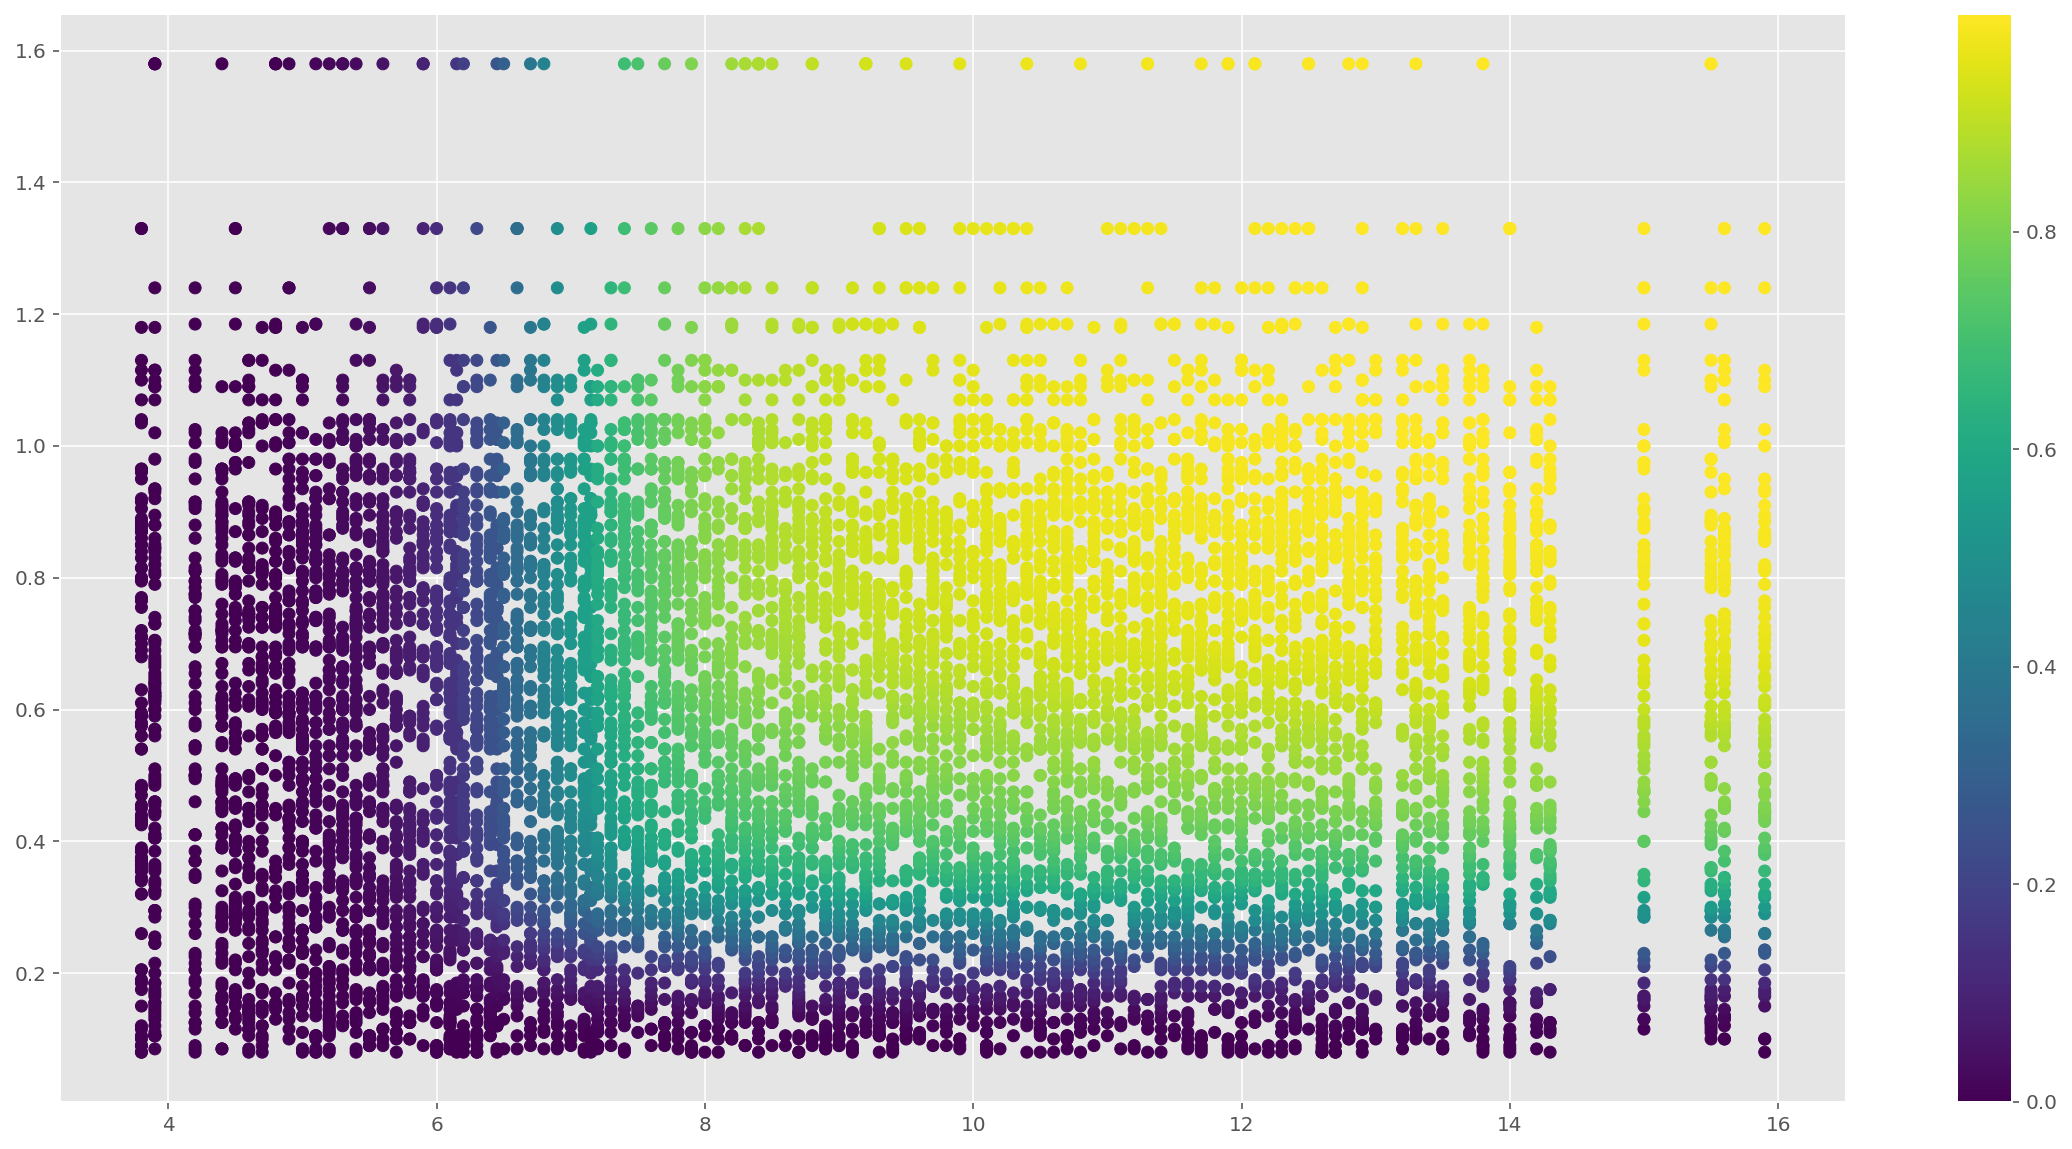

In [ ]:
fig = plt.figure(figsize=(20, 10))
ax = fig.gca()
X = train_X[:, 1]
Y = train_X[:, 3]
V = train_Y
sc = ax.scatter(X, Y, c=V)
plt.colorbar(sc)

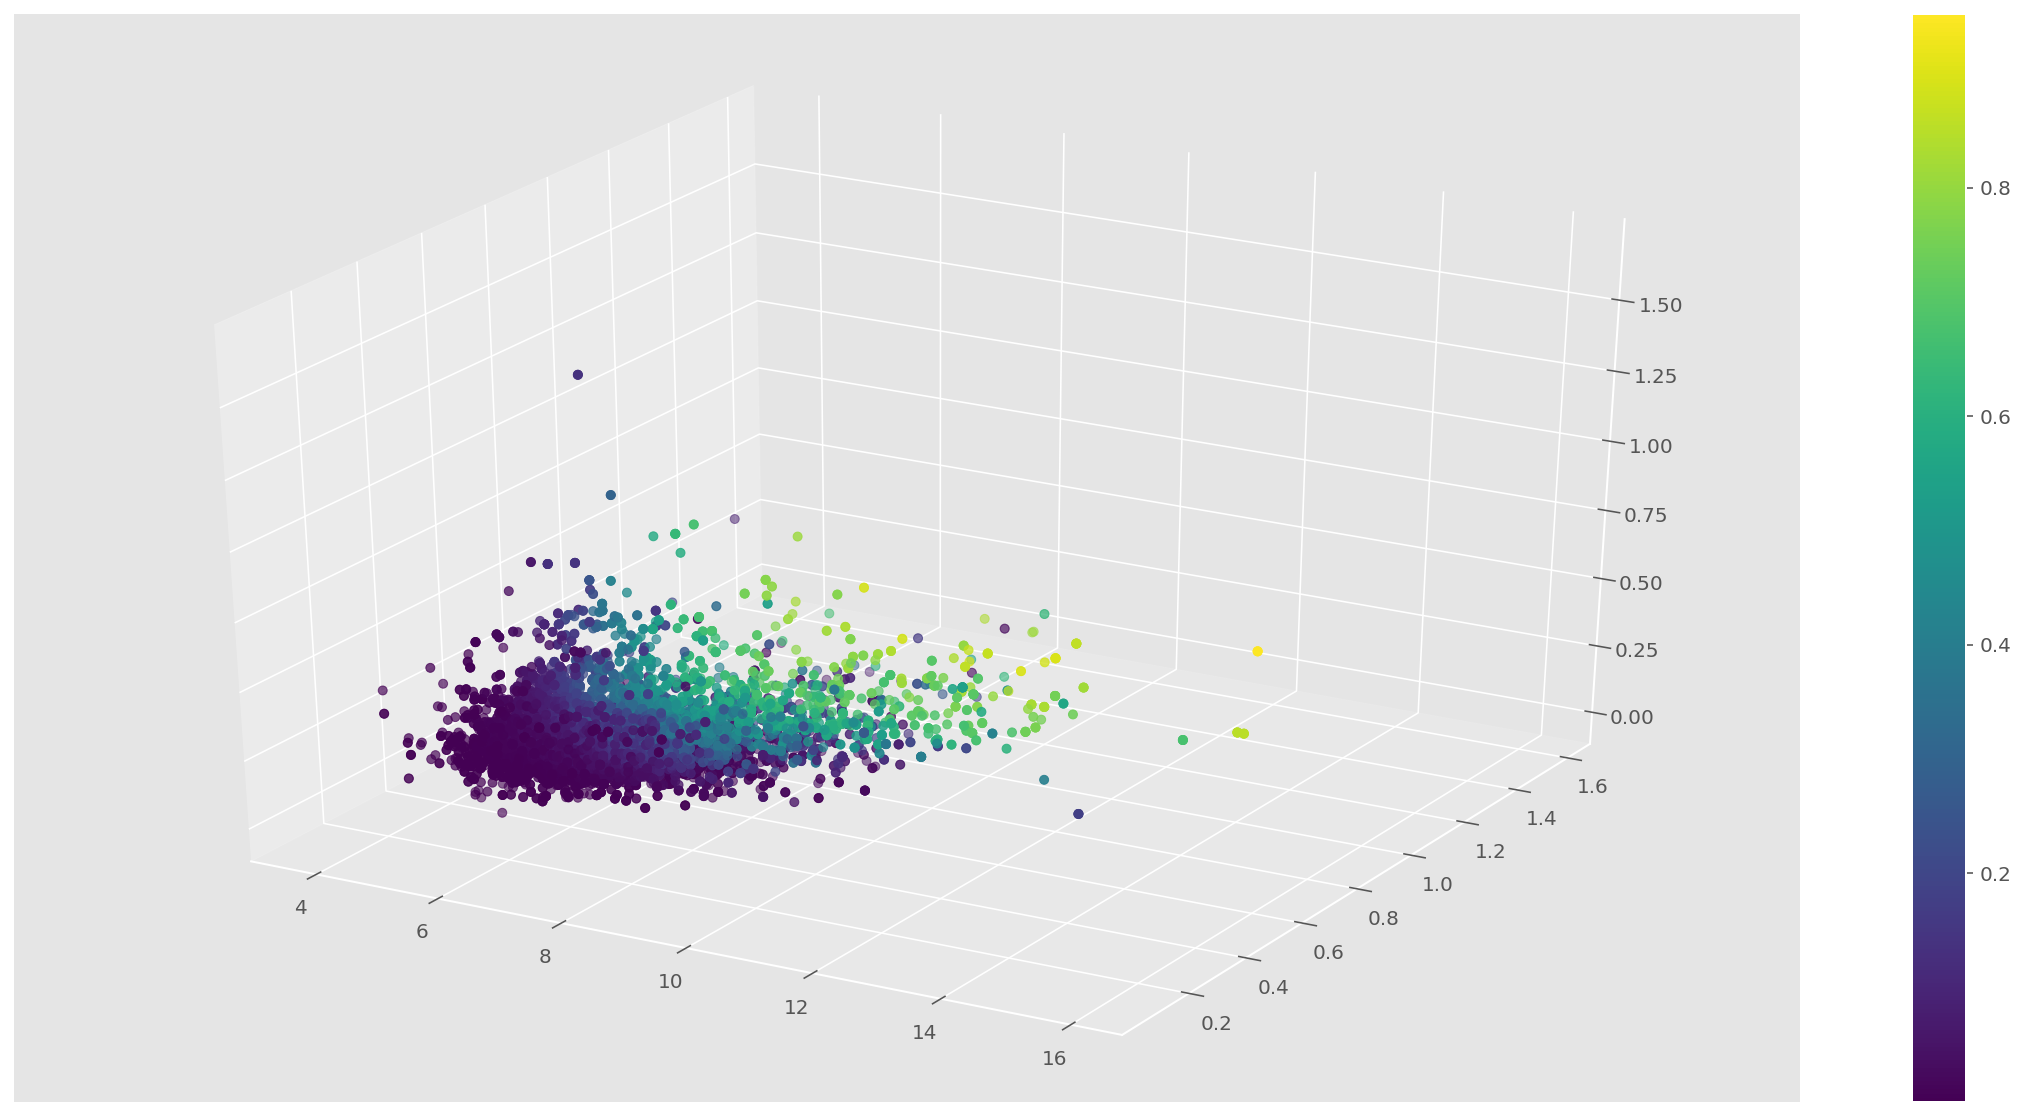

In [ ]:
fig = plt.figure(figsize=(20, 10))
ax = fig.gca(projection='3d')
X = train_X[:, 1]
Y = train_X[:, 3]
Z = train_X[:, 5]
V = train_Y
sc = ax.scatter(X, Y, Z, c=V)
plt.colorbar(sc)

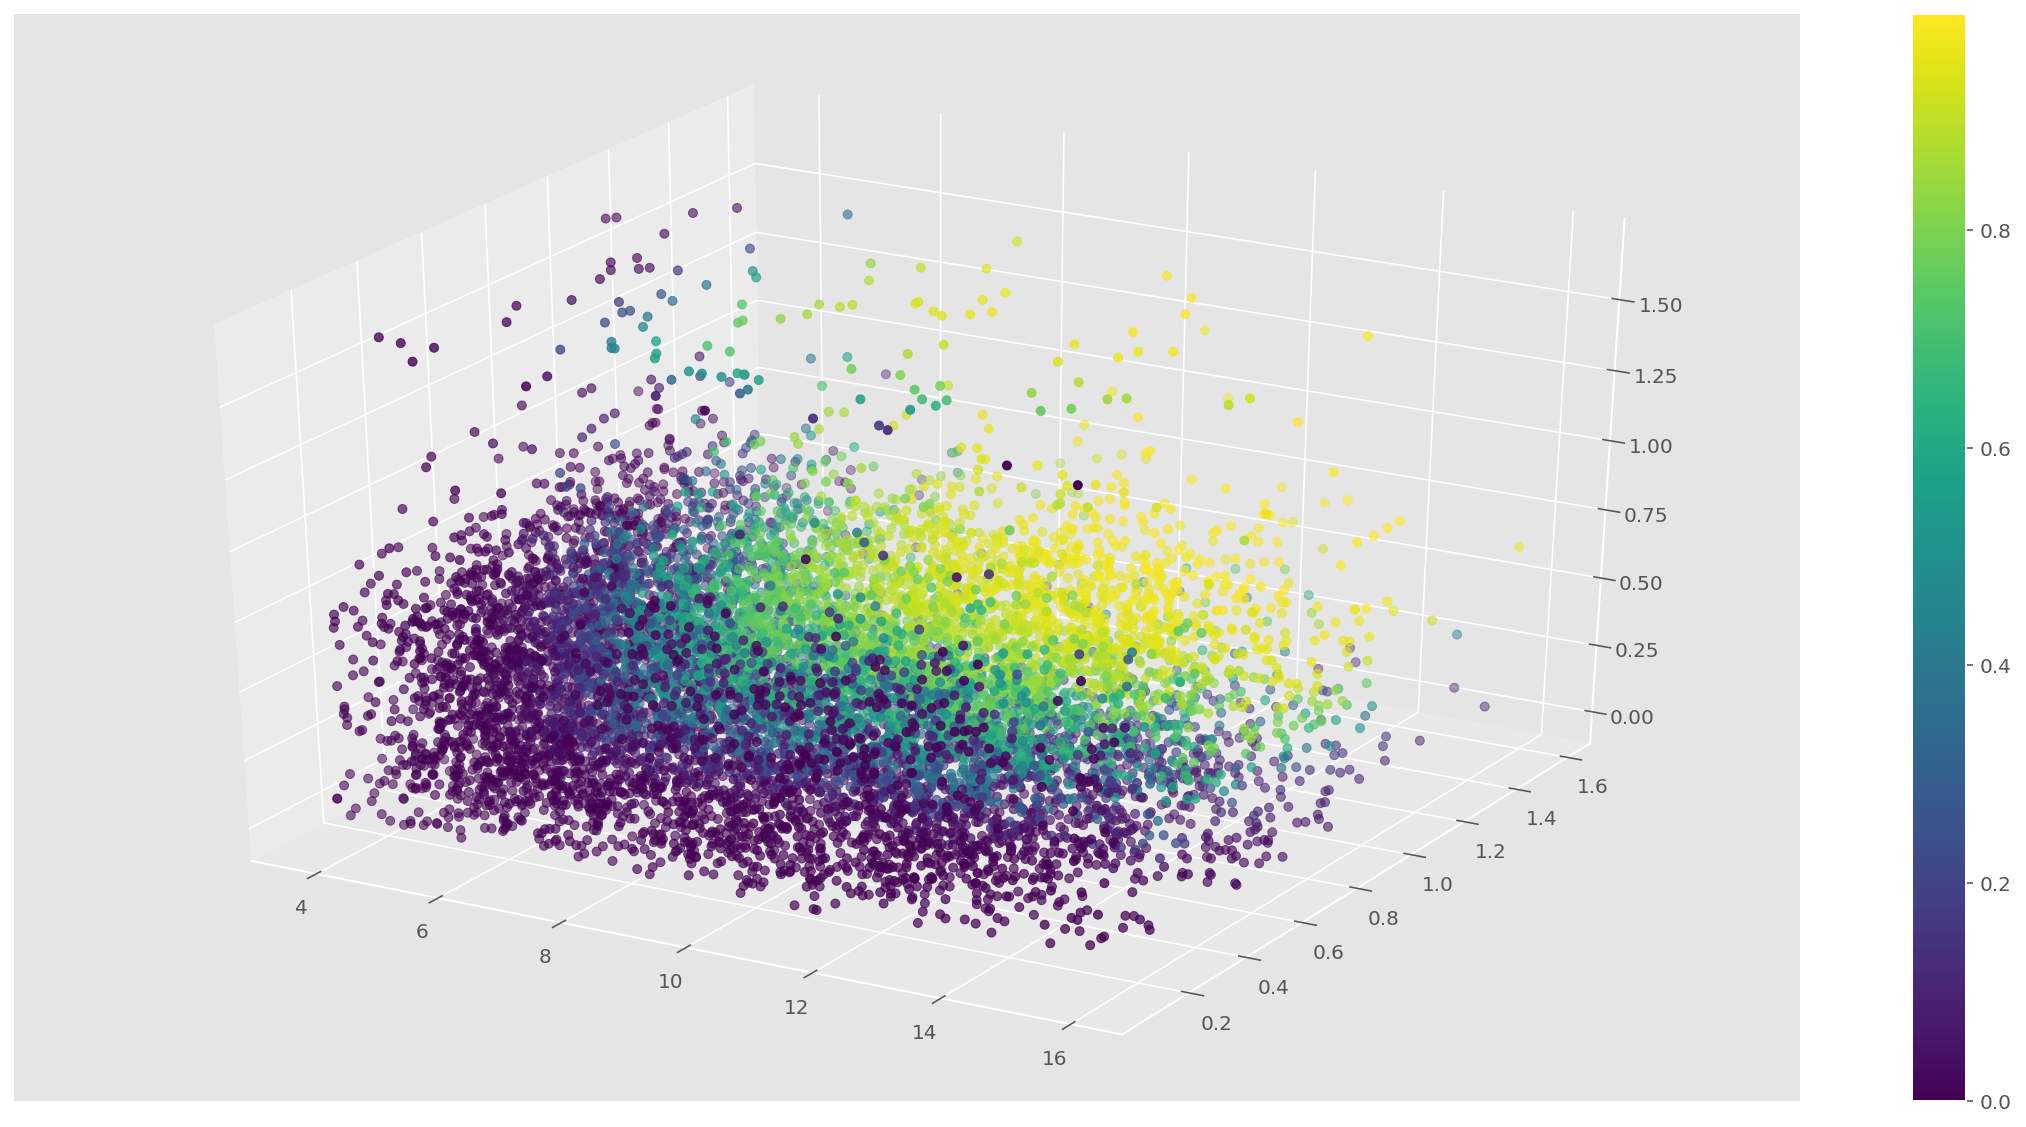

In [ ]:
%matplotlib inline
#notebook
fig = plt.figure(figsize=(20,10))
ax = fig.gca(projection='3d')
X = train_X[:, 1]
Y = train_X[:, 3]
Z = train_X[:, 5]
V = train_Y
sc = ax.scatter(X, Y, Z, c=V)
plt.colorbar(sc)

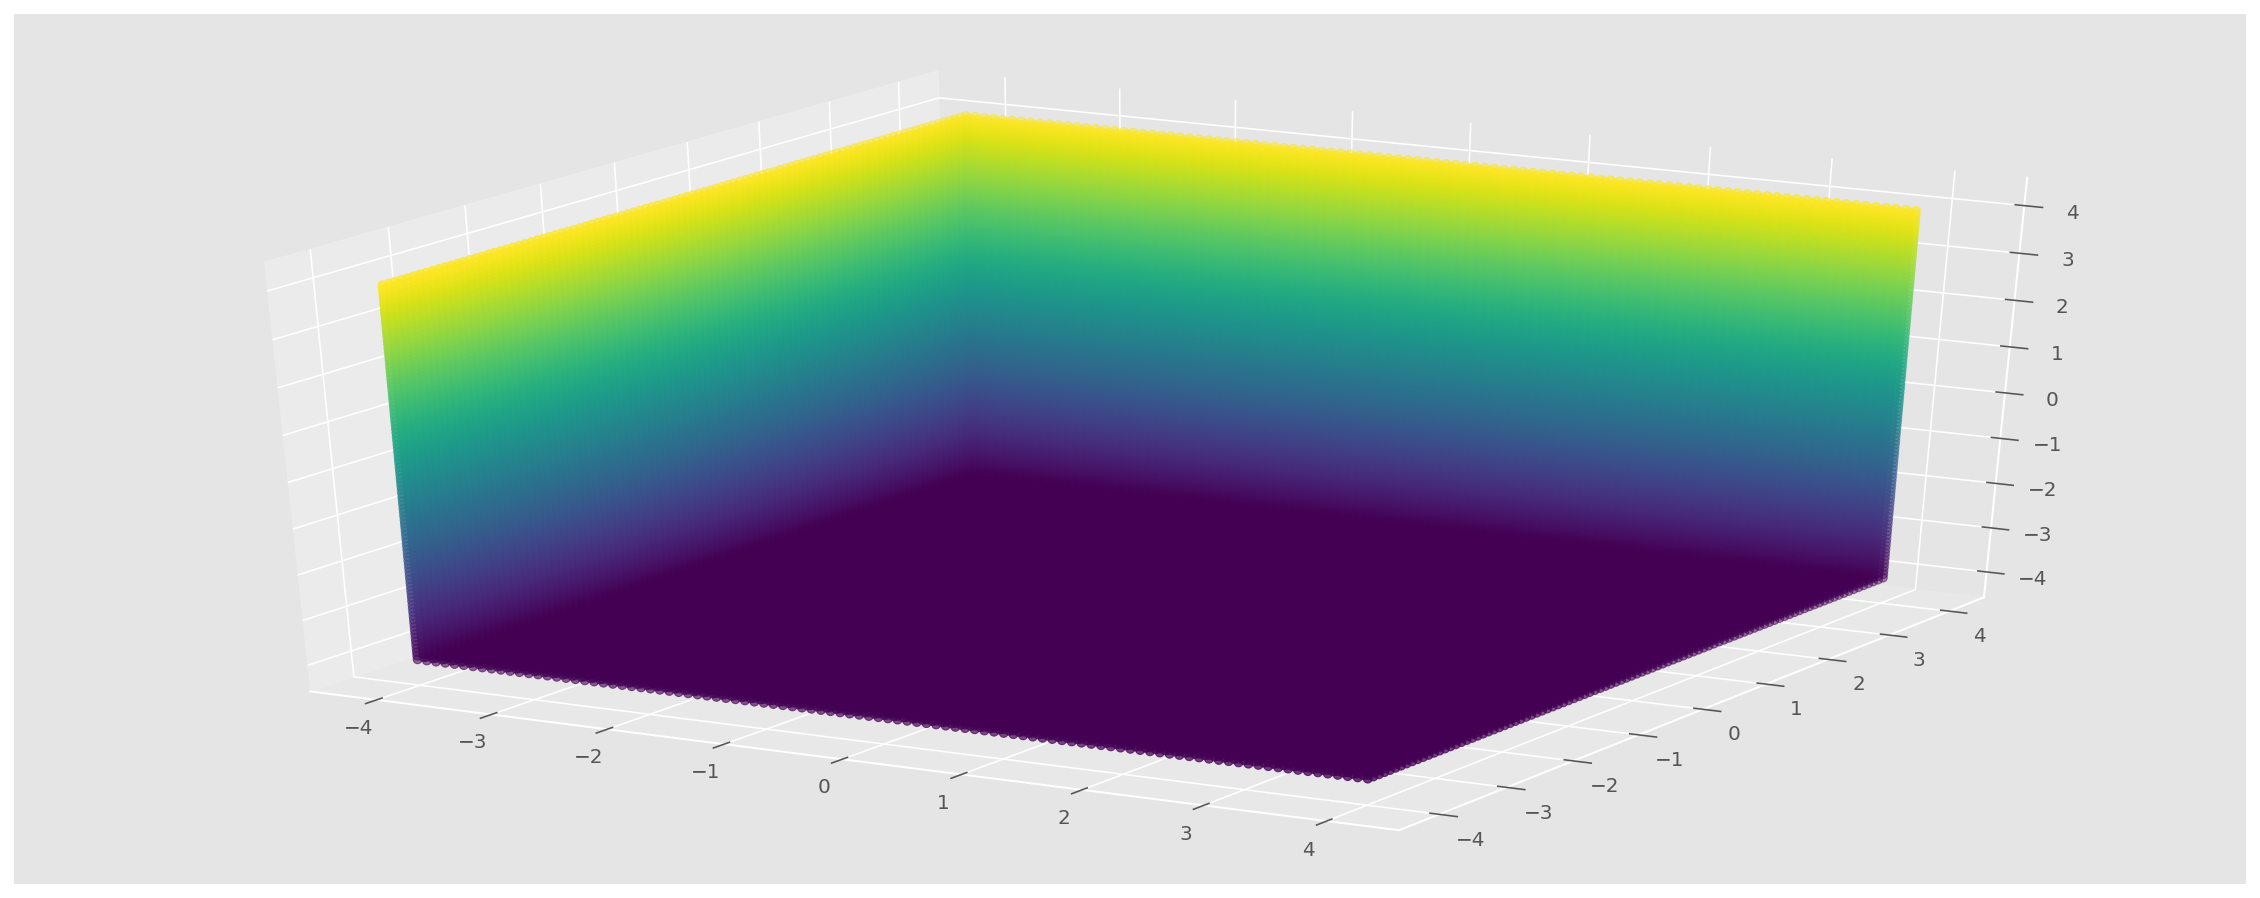

In [ ]:
x = y = z = np.linspace(-4.0, 4.0, 100)
X, Y, Z = np.meshgrid(x, y, z)
V = Z

fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(111, projection='3d')
#ax.plot_surface(X, Y, Z, facecolors=plt.cm.Oranges(V))
ax.scatter(X, Y, Z, c=V)
plt.show()

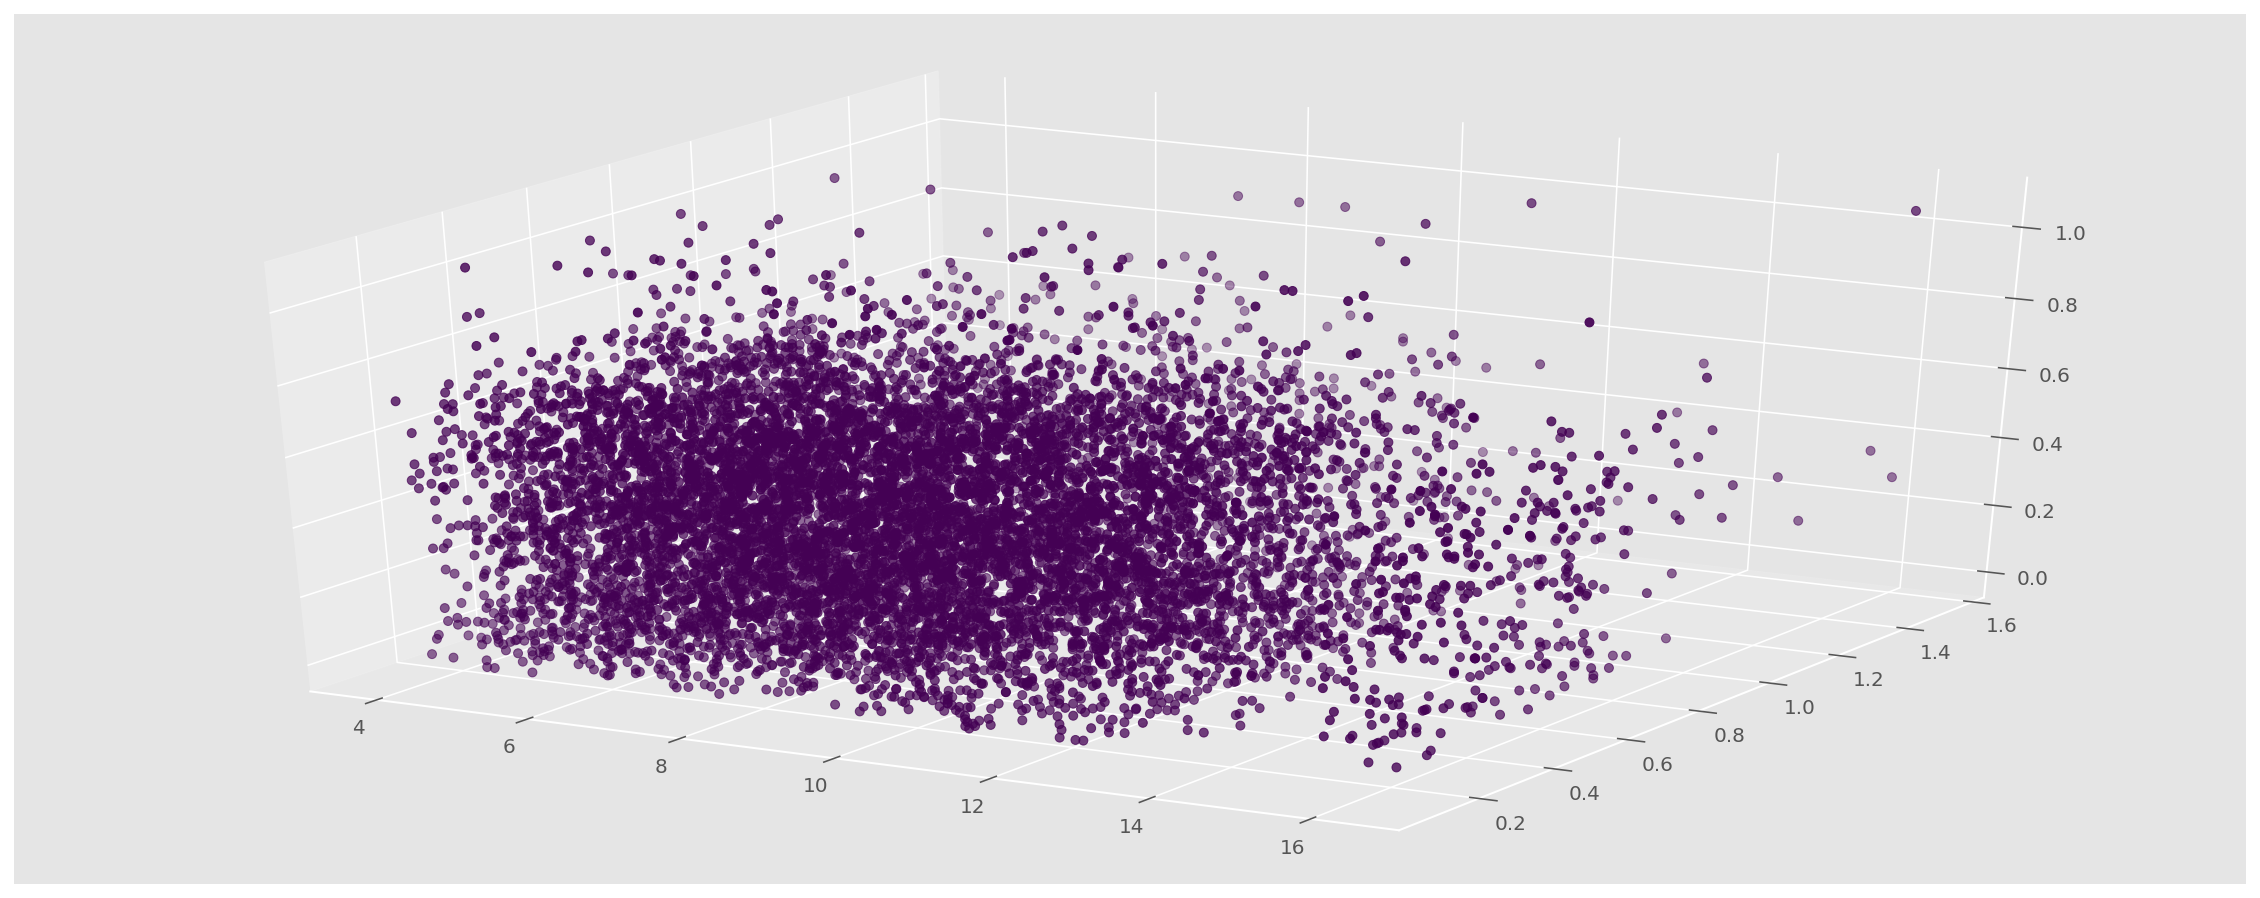

In [ ]:
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(111, projection='3d')
X = grid[:, 0]
Y = grid[:, 1]
Z = grid[:, 2]
V = newpred
ax.scatter(X, Y, Z, c=V)
plt.show()

In [ ]:
train_X, train_Y = process_train_data(unique_intervals, query_set)

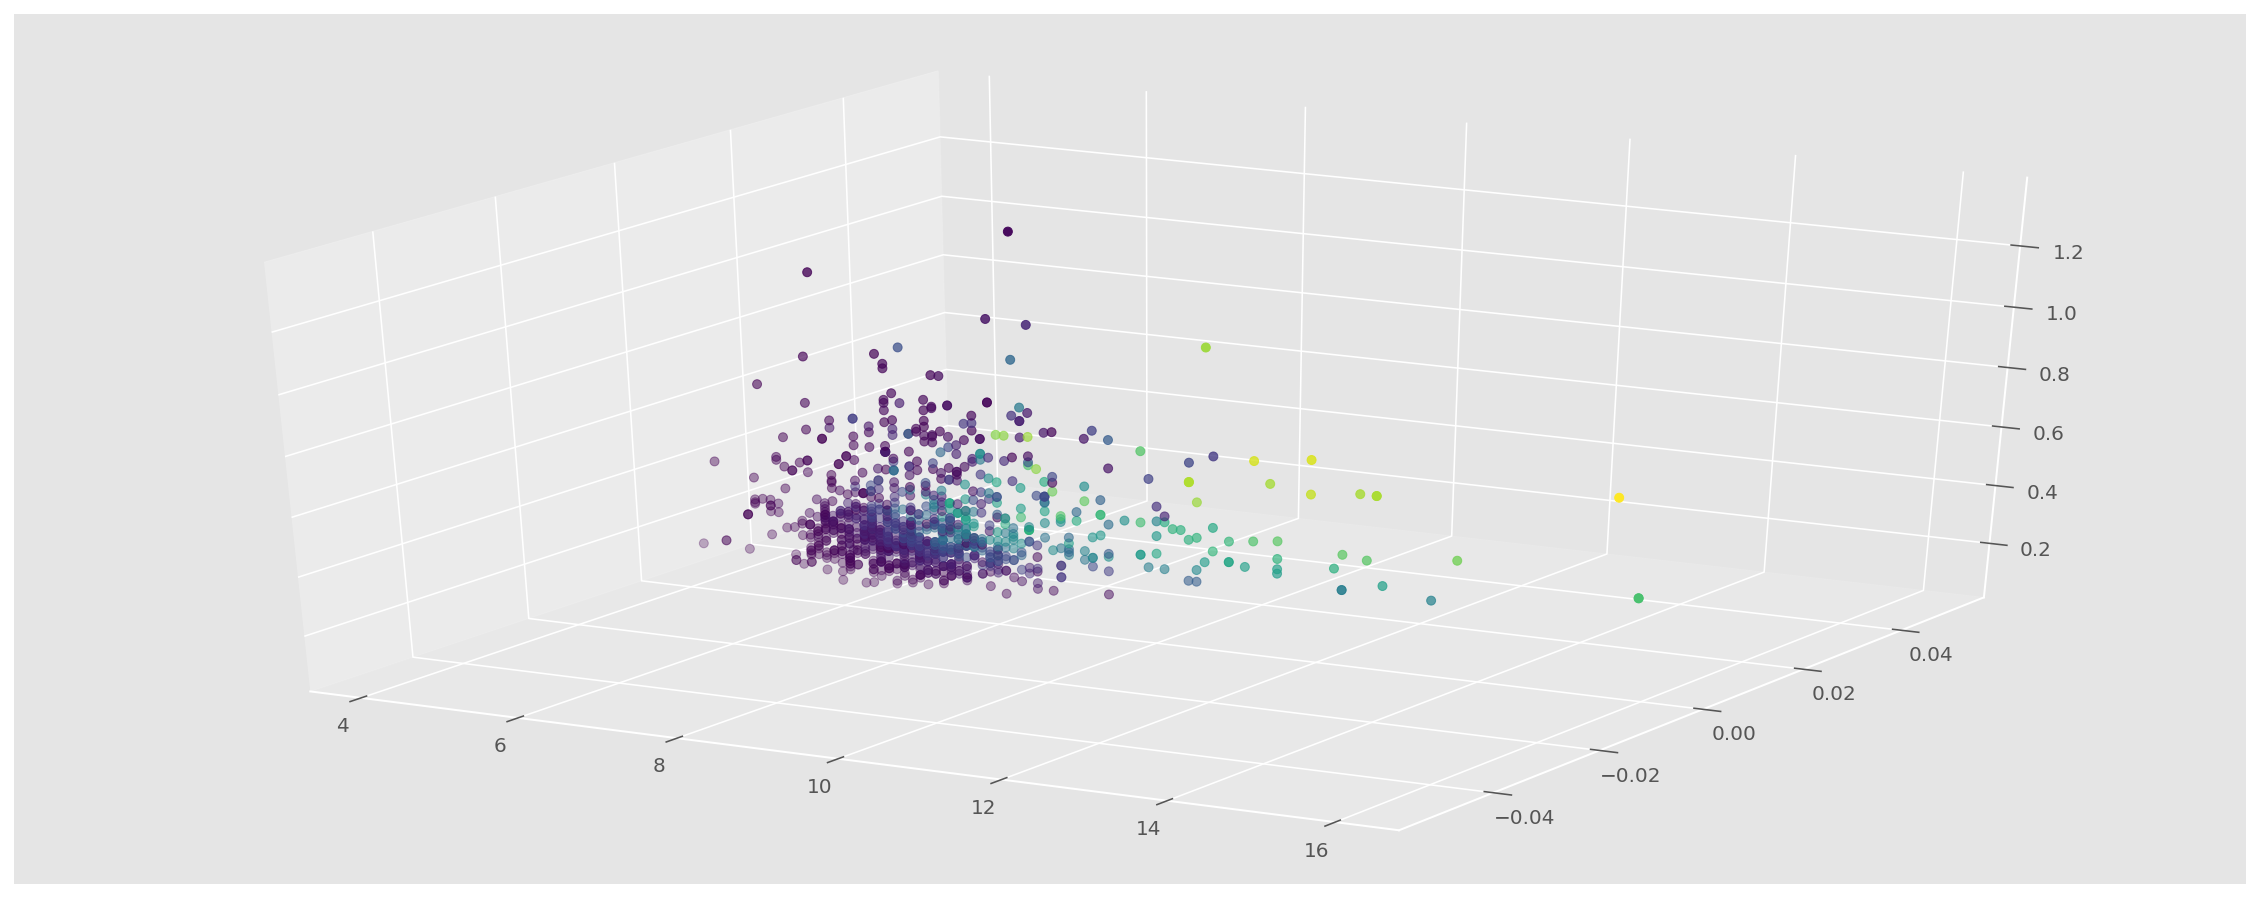

In [ ]:
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(111, projection='3d')
X = train_X[:, 1]
Y = train_X[:, 2]
Z = train_X[:, 3]
V = train_Y
ax.scatter(X, Y, Z, c=V)
plt.show()

In [ ]:
# 第一条，query的采样应该在网格中是均匀分布的
# 第二条，可以先计算每一列的CDF

(5000, 6)

In [ ]:
lhs(2, samples=4, criterion='center')

array([[0.125, 0.875],
       [0.875, 0.625],
       [0.625, 0.375],
       [0.375, 0.125]])

In [ ]:
lhs(2, samples=4, criterion='center')

array([[0.375, 0.125],
       [0.875, 0.625],
       [0.125, 0.375],
       [0.625, 0.875]])

In [ ]:
lhs(2, samples=8, criterion='center')

array([[0.1875, 0.0625],
       [0.5625, 0.4375],
       [0.8125, 0.8125],
       [0.3125, 0.5625],
       [0.0625, 0.3125],
       [0.4375, 0.1875],
       [0.9375, 0.9375],
       [0.6875, 0.6875]])